In [1]:
import zipfile
import os
import time
from pathlib import Path
from datetime import datetime
from collections import defaultdict
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path
from IPython.display import display

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models.video import r3d_18
from torchvision import transforms

from glob import glob
from typing import List, Tuple
from tqdm import tqdm
from collections import defaultdict, Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')


zip_path = "/content/drive/MyDrive/Beilinson/dataset.zip"

extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

output_path = "/content/drive/MyDrive/Beilinson/figs"
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


# **Exploratory Data Analysis**


In [6]:
def video_duration_sec(video_path: Path) -> float:
    try:
        cap = cv2.VideoCapture(str(video_path))
        fps = cap.get(cv2.CAP_PROP_FPS)
        frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        cap.release()
        return round(frames / fps, 2) if fps else 0.0
    except Exception as e:
        print(f"[ERROR] {video_path}: {e}")
        return 0.0

def seconds_to_mmss(seconds: float) -> str:
    m, s = divmod(int(seconds), 60)
    return f"{m}:{s:02d}"

# def mmss_to_seconds(t: str) -> int:
#     m, s = map(int, t.split(":"))
#     return m * 60 + s

def gather_video_metadata(root_dir: str) -> pd.DataFrame:
    video_exts = {'.mp4', '.avi', '.mov', '.mkv', '.wmv'}
    records = []

    for video_file in Path(root_dir).rglob("*"):
        if video_file.suffix.lower() in video_exts:
            try:
                category = video_file.parent.name
                size_mb = round(video_file.stat().st_size / (1024 ** 2), 2)
                modified = datetime.fromtimestamp(video_file.stat().st_mtime).strftime('%Y-%m-%d %H:%M')
                duration = video_duration_sec(video_file)
                records.append({
                    'Category': category,
                    'Filename': video_file.name,
                    'Format': video_file.suffix[1:],
                    'Size_MB': size_mb,
                    'Duration_sec': duration,
                    'Modified': modified
                    # 'filepath': str(video_file)
                })
            except Exception as e:
                print(f"[ERROR] Failed to process {video_file}: {e}")

    return pd.DataFrame(records)

def summarize_videos(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame()

    summary = (
        df.groupby('Category')
          .agg(
              Total_Videos=('Filename', 'count'),
              Formats=('Format', lambda x: ', '.join(f"{f}: {x.tolist().count(f)}" for f in set(x))),
              Total_Size_MB=('Size_MB', 'sum'),
              Size_Std_MB=('Size_MB', lambda x: round(x.std(), 2) if len(x) > 1 else 0),
              Total_Duration=('Duration_sec', 'sum'),
              Duration_Std=('Duration_sec', lambda x: x.std() if len(x) > 1 else 0)
          )
          .reset_index()
    )

    summary['Total_Duration'] = summary['Total_Duration'].apply(seconds_to_mmss)
    summary['Duration_Std'] = summary['Duration_Std'].apply(seconds_to_mmss)

    # Add overall total row
    total_row = {
        'Category': 'All',
        'Total_Videos': df.shape[0],
        'Formats': 'All',
        'Total_Size_MB': round(df['Size_MB'].sum(), 2),
        'Size_Std_MB': round(df['Size_MB'].std(), 2) if len(df) > 1 else 0,
        'Total_Duration': seconds_to_mmss(df['Duration_sec'].sum()),
        'Duration_Std': seconds_to_mmss(df['Duration_sec'].std() if len(df) > 1 else 0)
    }
    summary = pd.concat([summary, pd.DataFrame([total_row])], ignore_index=True)

    return summary


def analyze_video_data(df: pd.DataFrame, summary_df: pd.DataFrame, output_dir: str = "./figs"):
    os.makedirs(output_dir, exist_ok=True)

    print("Summary Overview:")
    display(summary_df)
    print("\nVideo Details:")
    display(df.head())

    fig_size = (12, 6)

    # Bar plot: number of videos per category
    plt.figure(figsize=fig_size)
    video_counts = df['Category'].value_counts()
    bars = plt.bar(video_counts.index, video_counts.values, color='skyblue')
    plt.title("Number of Videos by Category")
    plt.xlabel("Exercise Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 f"{int(bar.get_height())}", ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/video_count_per_category.png")
    plt.show()

    # Boxplot: duration by category
    plt.figure(figsize=fig_size)
    sns.boxplot(data=df, x='Category', y='Duration_sec', palette='pastel')
    plt.title("Video Duration by Category")
    plt.xlabel("Exercise")
    plt.ylabel("Seconds")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/duration_by_category.png")
    plt.show()

    # Boxplot: duration by category without outliers
    no_outliers_df = df[~df['Category'].isin(['plank', 'romanian deadlift'])]

    plt.figure(figsize=fig_size)
    sns.boxplot(data=no_outliers_df, x='Category', y='Duration_sec', palette='pastel')
    plt.title("Video Duration by Category Without Outliers")
    plt.xlabel("Exercise")
    plt.ylabel("Seconds")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/duration_by_category_without_outliers.png")
    plt.show()

    # Boxplot: duration by category for short clips only
    short_df = df[df['Duration_sec'] < 60]
    if not short_df.empty:
        plt.figure(figsize=fig_size)
        sns.boxplot(data=short_df, x='Category', y='Duration_sec', palette='Set2')
        plt.title("Short Videos (<60s) by Category")
        plt.xlabel("Exercise")
        plt.ylabel("Seconds")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/short_videos_boxplot.png")
        plt.show()

    # Boxplot: video file size by category
    plt.figure(figsize=fig_size)
    sns.boxplot(data=df, x='Category', y='Size_MB', palette='Set3')
    plt.title("Video File Size by Category")
    plt.xlabel("Exercise")
    plt.ylabel("Size (MB)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/size_by_category.png")
    plt.show()

In [7]:
video_df = gather_video_metadata("/content/dataset")
summary_df = summarize_videos(video_df)


Summary Overview:


,Category,Total_Videos,Formats,Total_Size_MB,Size_Std_MB,Total_Duration,Duration_Std
0,barbell biceps curl,62,mp4: 62,82.84,1.67,3:58,0:02
1,bench press,61,mp4: 61,110.92,2.97,3:49,0:04
2,chest fly machine,28,mp4: 28,55.33,4.24,2:55,0:05
3,deadlift,32,mp4: 32,65.31,4.53,3:07,0:06
4,decline bench press,12,"mp4: 6, MOV: 6",427.35,36.18,2:58,0:08
5,hammer curl,19,"mp4: 12, MOV: 7",364.64,19.80,3:05,0:05
6,hip thrust,18,"mp4: 14, MOV: 4",251.24,15.29,3:33,0:09
7,incline bench press,33,mp4: 33,140.33,8.19,4:25,0:11
8,lat pulldown,51,mp4: 51,107.20,2.22,3:41,0:02
9,lateral raise,37,"mp4: 31, MOV: 6",422.71,16.90,5:07,0:04



Video Details:


,Category,Filename,Format,Size_MB,Duration_sec,Modified
0,t bar row,t bar row_5.MOV,MOV,30.81,14.85,2025-07-22 11:30
1,t bar row,t bar row_6.MOV,MOV,27.97,13.48,2025-07-22 11:30
2,t bar row,t bar row_11.mp4,mp4,3.24,5.17,2025-07-22 11:30
3,t bar row,t bar row_13.mp4,mp4,2.45,3.59,2025-07-22 11:30
4,t bar row,t bar row_2.MOV,MOV,36.11,17.15,2025-07-22 11:30


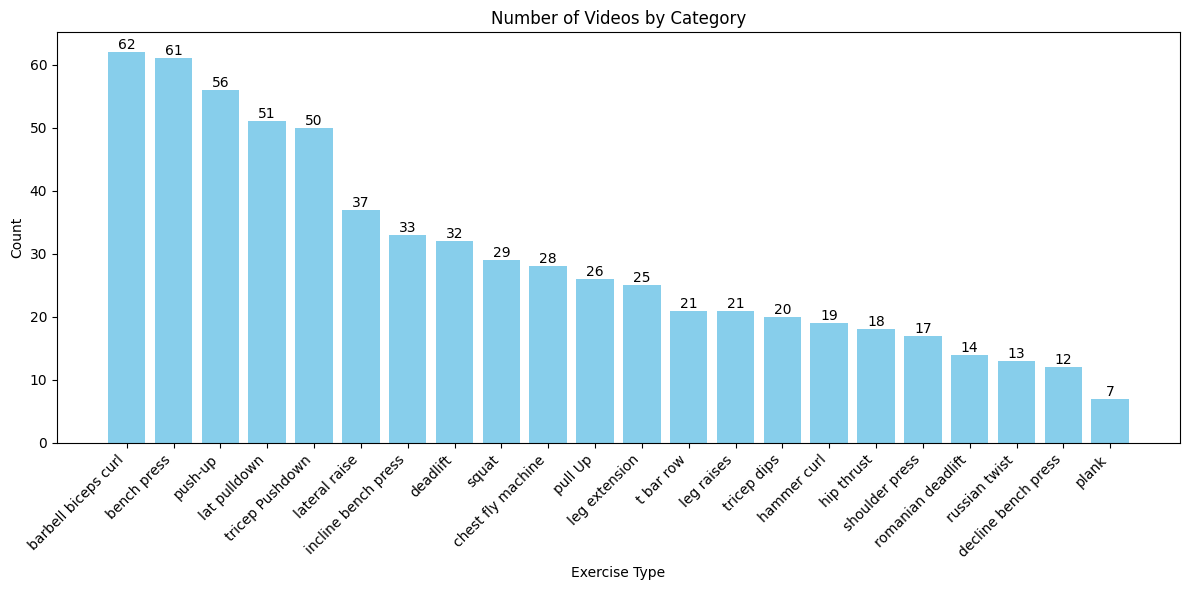

/tmp/ipython-input-6-615794973.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Duration_sec', palette='pastel')


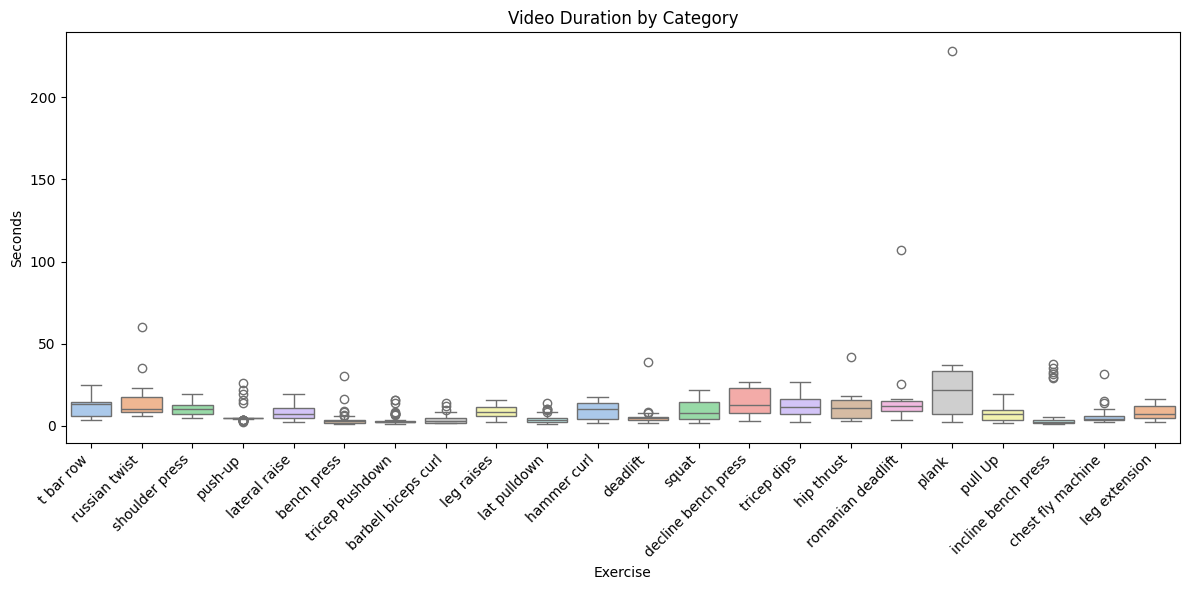

/tmp/ipython-input-6-615794973.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=no_outliers_df, x='Category', y='Duration_sec', palette='pastel')


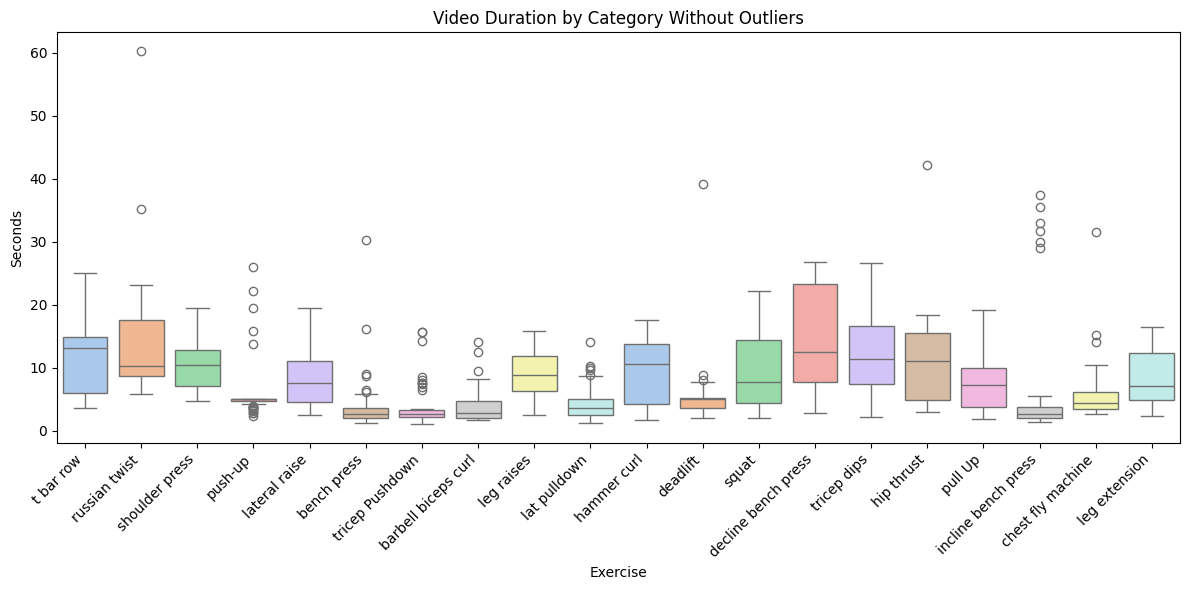

/tmp/ipython-input-6-615794973.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=short_df, x='Category', y='Duration_sec', palette='Set2')


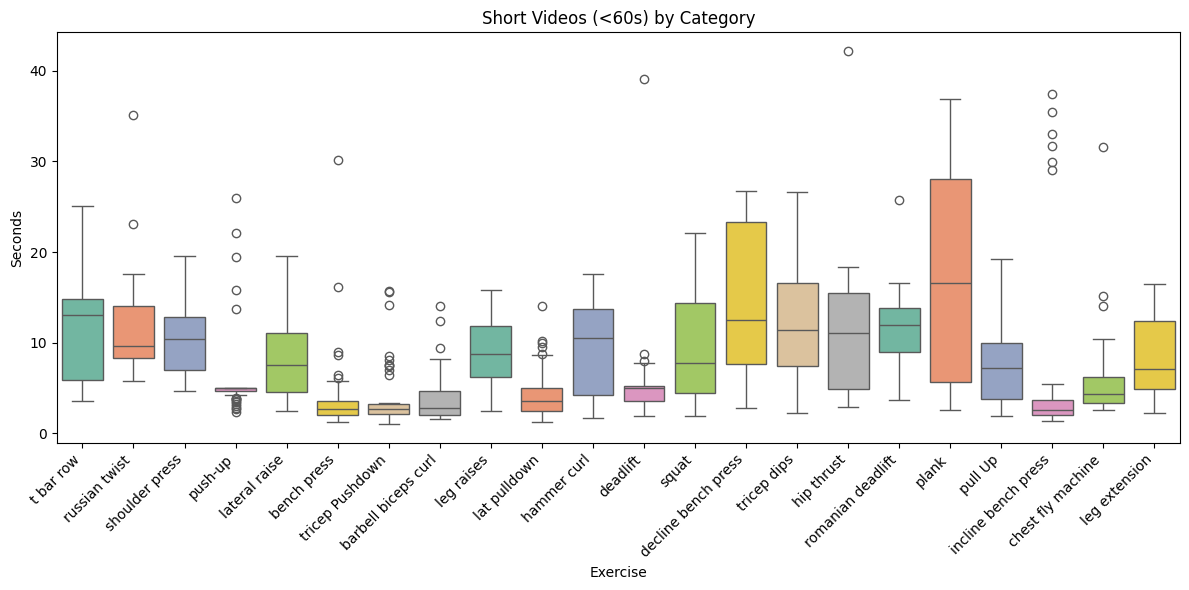

/tmp/ipython-input-6-615794973.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Size_MB', palette='Set3')


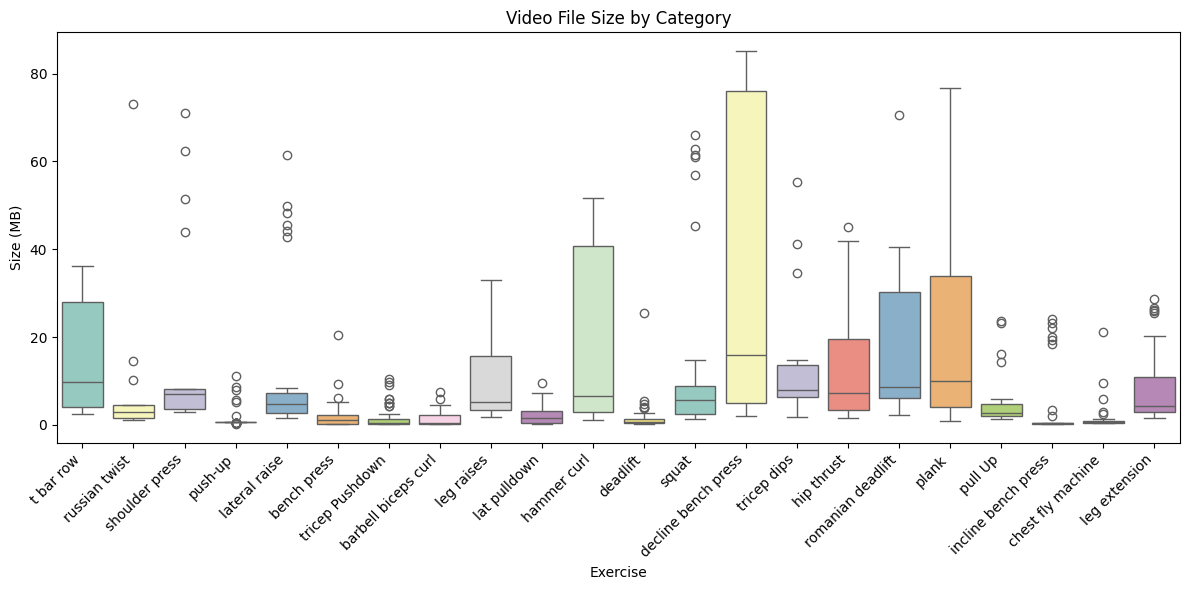

In [8]:
analyze_video_data(video_df, summary_df, output_dir=output_path)

# **Data Preprocess**

### **Built Dataset**

In [3]:
def build_dataframe_from_folder(root_dir: str, extensions=('.mp4', '.avi', '.mov')) -> Tuple[pd.DataFrame, dict]:
    data = []
    label_map = {}
    for i, class_folder in enumerate(sorted(os.listdir(root_dir))):
        class_path = os.path.join(root_dir, class_folder)
        if not os.path.isdir(class_path):
            continue
        label_map[class_folder] = i
        for fname in glob(os.path.join(class_path, '*')):
            if fname.lower().endswith(extensions):
                data.append({
                    'filepath': fname,
                    'label': i,
                    'category': class_folder
                })
    return pd.DataFrame(data), label_map


In [4]:
root_dir = "/content/dataset"
df, label_map = build_dataframe_from_folder(root_dir)
df.head()


,filepath,label,category
0,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl
1,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl
2,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl
3,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl
4,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl


In [18]:
label_map

{'barbell biceps curl': 0,
 'bench press': 1,
 'chest fly machine': 2,
 'deadlift': 3,
 'decline bench press': 4,
 'hammer curl': 5,
 'hip thrust': 6,
 'incline bench press': 7,
 'lat pulldown': 8,
 'lateral raise': 9,
 'leg extension': 10,
 'leg raises': 11,
 'plank': 12,
 'pull Up': 13,
 'push-up': 14,
 'romanian deadlift': 15,
 'russian twist': 16,
 'shoulder press': 17,
 'squat': 18,
 't bar row': 19,
 'tricep Pushdown': 20,
 'tricep dips': 21}

### **Data Split**

In [5]:
def prepare_split_dataframe(df: pd.DataFrame, output_dir: str, test_size=0.2, val_size=0.1, seed=42):
    train_df, temp_df = train_test_split(df, test_size=(test_size + val_size), stratify=df['label'], random_state=seed)
    relative_val_size = val_size / (test_size + val_size)
    val_df, test_df = train_test_split(temp_df, test_size=1 - relative_val_size, stratify=temp_df['label'], random_state=seed)

    # Save as CSVs
    os.makedirs(output_dir, exist_ok=True)
    train_df.to_csv(f"{output_dir}/train.csv", index=False)
    val_df.to_csv(f"{output_dir}/val.csv", index=False)
    test_df.to_csv(f"{output_dir}/test.csv", index=False)

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [6]:
splits_dir = "/content/drive/MyDrive/Beilinson/splits"

train_df, val_df, test_df = prepare_split_dataframe(df, output_dir=splits_dir)


In [15]:
train_df

,filepath,label,category
0,/content/dataset/bench press/bench press_24.mp4,1,bench press
1,/content/dataset/t bar row/t bar row_7.MOV,19,t bar row
2,/content/dataset/tricep dips/tricep dips_9.mp4,21,tricep dips
3,/content/dataset/deadlift/deadlift_24.mp4,3,deadlift
4,/content/dataset/bench press/bench press_11.mp4,1,bench press
...,...,...,...
451,/content/dataset/incline bench press/incline b...,7,incline bench press
452,/content/dataset/hammer curl/hammer curl_14.mp4,5,hammer curl
453,/content/dataset/incline bench press/incline b...,7,incline bench press
454,/content/dataset/barbell biceps curl/barbell b...,0,barbell biceps curl


In [17]:
# Count per category for each split
train_counts = train_df['label'].value_counts().rename('Train')
val_counts = val_df['label'].value_counts().rename('Validation')
test_counts = test_df['label'].value_counts().rename('Test')

# Combine into single DataFrame
split_summary = pd.concat([train_counts, val_counts, test_counts], axis=1).fillna(0).astype(int)

# Display the summary
display(split_summary)


,Train,Validation,Test
label,,,
1,43,6,12
0,43,6,13
14,39,5,12
8,36,5,10
20,35,5,10
9,26,4,7
7,23,3,7
3,22,3,7
18,20,3,6


### **Video Dataset Construction**

The `VideoClipDataset` class loads multiple short clips from raw video files for training 3D CNN models.
Each clip is treated as a separate training sample. Specifically, the dataset:

* Extracts up to N clips of T consecutive frames (e.g., 16) from each video, evenly spaced across the video's duration

* Automatically backtracks to earlier frames if a full-length clip cannot be extracted from the end

* Supports short videos by looping the beginning frames to fill the clip if necessary

* Applies resizing, normalization, and format conversion to each frame

* Stacks the frames into a tensor of shape (3, T, 112, 112)

* Returns each clip along with its corresponding label

This design enables efficient and consistent on-the-fly loading of video segments, ensuring full usage of each video regardless of length or resolution, without needing to preprocess the entire dataset.



In [27]:
## Check if there is a video with less then 16 frames
def get_fps_and_num_frames(filepath):
    cap = cv2.VideoCapture(filepath)
    if not cap.isOpened():
        print(f"Failed to open {filepath}")
        return None, None
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration_sec = cap.get(cv2.CAP_PROP_FRAME_COUNT) / fps if fps > 0 else 0
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return fps, num_frames

fps_list = []
num_frames_list = []

for filepath in df["filepath"]:
    path = os.path.join(root_dir, filepath)
    fps, num_frames = get_fps_and_num_frames(path)
    fps_list.append(fps)
    num_frames_list.append(num_frames)

df["FPS"] = fps_list
df["Num_Frames"] = num_frames_list

short_videos = df[df["Num_Frames"] < 16]
print("Videos with fewer than 16 frames:")
print(short_videos)

Videos with fewer than 16 frames:
Empty DataFrame
Columns: [filepath, label, category, FPS, Num_Frames]
Index: []


In [7]:
class VideoClipDataset(Dataset):
    """
    A PyTorch Dataset that extracts multiple temporal clips from each video.
    Each clip has a fixed number of frames (clip_len), and every clip is returned as an independent sample.

    Parameters:
    - df (pd.DataFrame): Must include 'filepath' and 'label' columns.
    - clip_len (int): Number of frames per clip.
    - num_clips_per_video (int): How many clips to sample from each video (evenly spaced).
    - resize (tuple): (H, W) target size for each frame.
    - allow_short (bool): Whether to include videos shorter than clip_len by looping frames.
    """

    def __init__(self, df, clip_len=16, num_clips_per_video=5, resize=(112, 112), allow_short=True):
        """
        Initialize the dataset and prepare the (video_path, label, start_frame) samples list.
        """
        self.clip_len = clip_len
        self.resize = resize
        self.allow_short = allow_short
        self.samples = []  # list of tuples: (filepath, label, clip_start_index)

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.resize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])
        ])

        for _, row in df.iterrows():
            path = row['filepath']
            label = row['label']

            cap = cv2.VideoCapture(path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()

            if total_frames < self.clip_len:
                if not allow_short:
                    continue
                else:
                    # Include one clip starting at frame 0 with looping logic
                    self.samples.append((path, label, 0))
                    continue

            # Uniform sampling of start indices
            max_start = total_frames - self.clip_len
            if num_clips_per_video == 1:
                starts = [max_start // 2]
            else:
                step = max_start // (num_clips_per_video - 1)
                starts = [i * step for i in range(num_clips_per_video)]

            for s in starts:
                self.samples.append((path, label, s))

    def __len__(self):
        """
        Return total number of clips across all videos.
        """
        return len(self.samples)

    def _load_clip(self, path, start_idx):
        """
        Load a clip of self.clip_len frames starting at start_idx from a video.

        Inputs:
        - path (str): path to the video file
        - start_idx (int): starting frame index

        Output:
        - clip (torch.Tensor): Tensor of shape [3, T, H, W]
        """
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Adjust if not enough frames remain
        if total_frames - start_idx < self.clip_len:
            start_idx = max(0, total_frames - self.clip_len)

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_idx)
        frames = []

        for _ in range(self.clip_len):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.transform(frame)
            frames.append(frame)

        cap.release()

        # Loop over beginning if clip is too short
        while len(frames) < self.clip_len:
            needed = self.clip_len - len(frames)
            loop_frames = frames[:needed]
            frames.extend(loop_frames)

        return torch.stack(frames, dim=1)  # [C, T, H, W]

    def __getitem__(self, idx):
        """
        Retrieve a single clip and its label.

        Input:
        - idx (int): index of the clip sample

        Output:
        - clip (Tensor): shape [3, clip_len, H, W]
        - label (int): class label
        - path (str): path to the video file
        """
        path, label, start_idx = self.samples[idx]
        clip = self._load_clip(path, start_idx)
        return clip, label, path

    def __repr__(self):
        """
        Return a string summary when printing the dataset object.
        """
        total_videos = len(set([path for path, _, _ in self.samples]))
        return (
            f"ExpandedVideoClipDataset\n"
            f"{'-'*25}\n"
            f"Total video files: {total_videos}\n"
            f"Total clips: {len(self)}\n"
            f"Clip length: {self.clip_len} frames\n"
            f"Target size: {self.resize[0]}x{self.resize[1]}\n"
            f"Short videos allowed: {self.allow_short}\n"
            f"Clips per video: approx. {len(self.samples)//total_videos if total_videos > 0 else 0}"
        )

    def summary(self, label_names: dict = None):
        """
        Print number of clips per label.

        Parameters:
        - label_names (dict): Optional mapping from label index to category name
        """
        from collections import Counter
        clip_counts = Counter([label for _, label, _ in self.samples])

        print("Clips per label:")
        for label, count in sorted(clip_counts.items()):
            name = label_names[label] if label_names else str(label)
            print(f"  {name:20s}: {count} clips")


#### Train

In [18]:
train_dataset = VideoClipDataset(train_df, clip_len=16, num_clips_per_video=5, allow_short=True)
print("Samples in dataset:", len(dataset))

Samples in dataset: 2280
Clip shape: torch.Size([3, 16, 112, 112])
Label: 1


In [21]:
train_dataset

ExpandedVideoClipDataset
-------------------------
Total video files: 456
Total clips: 2280
Clip length: 16 frames
Target size: 112x112
Short videos allowed: True
Clips per video: approx. 5

In [22]:
inv_map = {v: k for k, v in label_map.items()}

train_dataset.summary(label_names=inv_map)

Clips per label:
  barbell biceps curl : 215 clips
  bench press         : 215 clips
  chest fly machine   : 100 clips
  deadlift            : 110 clips
  decline bench press : 40 clips
  hammer curl         : 65 clips
  hip thrust          : 65 clips
  incline bench press : 115 clips
  lat pulldown        : 180 clips
  lateral raise       : 130 clips
  leg extension       : 85 clips
  leg raises          : 75 clips
  plank               : 25 clips
  pull Up             : 90 clips
  push-up             : 195 clips
  romanian deadlift   : 50 clips
  russian twist       : 45 clips
  shoulder press      : 60 clips
  squat               : 100 clips
  t bar row           : 75 clips
  tricep Pushdown     : 175 clips
  tricep dips         : 70 clips


### Validation

In [ ]:
val_dataset = VideoClipDataset(val_df, clip_len=16, num_clips_per_video=5, allow_short=True)
print("Samples in dataset:", len(dataset))

In [ ]:
val_dataset

In [ ]:
val_dataset.summary(label_names=inv_map)

# **Model Architecture**

## **3D CNN**

### **Build model function**

In [12]:
def build_3d_cnn_model(num_classes: int, pretrained: bool = True) -> nn.Module:
    """
    Build a 3D ResNet-18 model for video classification.

    Args:
        num_classes (int): number of target classes
        pretrained (bool): whether to use pretrained weights on Kinetics-400

    Returns:
        nn.Module: a modified r3d_18 model with updated classifier head
    """
    model = r3d_18(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


### **Training loop**

In [23]:
def train_model(model, train_loader, val_loader, device, num_epochs=10, lr=1e-3, save_path=None):
    """
    Train a 3D CNN model on clips, and evaluate by majority vote per video.

    Args:
        model (nn.Module): the model to train
        train_loader (DataLoader): training data loader (per-clip)
        val_loader (DataLoader): validation loader (per-clip, includes filepath)
        device (torch.device): CUDA or CPU
        num_epochs (int): number of training epochs
        lr (float): learning rate
        save_path (str): path to save best model (based on video-level accuracy)

    Returns:
        model: the trained model
        history: dict with training and validation metrics per epoch
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # === TRAIN ===
        model.train()
        total, correct, running_loss = 0, 0, 0.0

        for clips, labels in train_loader:
            clips, labels = clips.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(clips)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)

        # === VALIDATION (majority vote per video) ===
        model.eval()
        val_preds = defaultdict(list)
        val_labels = {}

        val_running_loss = 0.0

        with torch.no_grad():
            for clips, labels, paths in val_loader:
                clips = clips.to(device)
                labels = labels.to(device)
                outputs = model(clips)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                preds = preds.cpu().numpy()
                labels = labels.cpu().numpy()

                for path, pred, label in zip(paths, preds, labels):
                    val_preds[path].append(pred)
                    val_labels[path] = label

        # Majority vote per video
        correct_videos = 0
        for path, pred_list in val_preds.items():
            final_pred = Counter(pred_list).most_common(1)[0][0]
            if final_pred == val_labels[path]:
                correct_videos += 1

        val_acc = correct_videos / len(val_preds)
        val_loss = val_running_loss / len(val_loader)

        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Save best model
        if save_path and val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return model, history



### **Save model**

In [14]:
def save_model(model: nn.Module, path: str):
    """
    Save a trained PyTorch model to disk.

    Args:
        model (nn.Module): the trained model
        path (str): path to .pt or .pth file
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model saved to: {path}")


### **Running**

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_df['label'].unique())
model = build_3d_cnn_model(num_classes)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=10,
    lr=1e-4,
    save_path="/content/drive/MyDrive/Beilinson/3dcnn_best_model.pt"
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 - Train:   0%|          | 0/57 [00:00<?, ?it/s]


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 268

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/frame.py", line 4102, in __getitem__
    indexer = self.columns.get_loc(key)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 268


In [ ]:

def plot_training_history(history, save_path=None):
    """
    Plot accuracy and loss curves from training history.

    Args:
        history (dict): output of train_model(), contains lists of train/val loss & accuracy
        save_path (str): folder to save the figure as PNG (optional)
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"📈 Plot saved to {save_path}")

    plt.show()

In [ ]:
plot_training_history(history, save_path= output_path)
